# FEE-PYX

## Optimization of FEE class

In [1]:
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext Cython
%matplotlib inline
%load_ext line_profiler

In [2]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [3]:
import tables

In [4]:
from LogConfig import *

In [5]:
import cProfile

In [6]:
import mplFunctions as mpl

In [8]:
from Util import *
from scipy import signal as SGN

In [24]:
###########################################################
class FEParam:
    """
    Defines the paramaters of the FE electronics for the EP
    """
    
    def __init__(self,pmt_gain=4.5e6,V_GAIN=250*ohm,R = 2350*ohm, 
                 C =np.array([ 6.02975448,  6.22547194,  6.0671337 ,  6.22159457,  6.29999787,
                 6.09892384,  6.18289435,  6.21775591,  6.19306671,  6.30518792,
                 6.20359891,  6.31231192])*nF, 
                 offset = 2500,ceiling = 4096, 
                 NBITS=12, NOISE_FEE_rms = 0.3*mV, freq_LPF=3E6*hertz,
                 time_DAQ=25*ns):
        
        self.pmt_gain = pmt_gain
        self.V_GAIN= V_GAIN
        self.R = R
        self.C = C
        self.C0 = self.C[0]
        self.offset = offset
        self.ceiling = ceiling
        self.NBITS = NBITS
        self.LSB = 2*volt/2**NBITS
        self.voltsToAdc = self.LSB/1.25
        self.NOISE_FEE = NOISE_FEE_rms
        self.NOISE_ADC = self.NOISE_FEE/self.voltsToAdc
        self.freq_LPF = freq_LPF
        self.time_DAQ = time_DAQ
        self.freq_HPF=(1/(2*pi*self.R*self.C0))
    
    def __repr__(self):
        return self.__str__()
        
    def __str__(self):
        
		s= """
		FEParam:
        pmt gain = {}
        V_gain = {} ohm
        RC HPF: R = {} ohm C[0] = {} nF
        NBITS={}, voltsToAdc = {} NOISE_FEE_rms = {} mV, NOISE_ADC = {}
        freq_LPF={} hertz, freq_HPF={} hertz time_DAQ={} ns
		""".format(self.pmt_gain,
        self.V_GAIN/ohm,
        self.R/ohm,
        self.C[0]/nF,
        self.NBITS, 
        self.voltsToAdc/volt,
        self.NOISE_FEE,
        self.NOISE_ADC,
        self.freq_LPF/hertz,self.freq_HPF/hertz,
        self.time_DAQ/ns)
		return s

In [25]:
fep = FEParam()

In [26]:
fep


		FEParam:
        pmt gain = 4500000.0
        V_gain = 250.0 ohm
        RC HPF: R = 2350.0 ohm C[0] = 6.02975448 nF
        NBITS=12, voltsToAdc = 0.000390625 NOISE_FEE_rms = 3e-10 mV, NOISE_ADC = 0.768
        freq_LPF=3000000.0 hertz, freq_HPF=11231.8848012 hertz time_DAQ=25.0 ns
		

In [72]:
import FEParam as FP
from Util import *
from scipy import signal as SGN
import numpy as np

###########################################################
class FEParam:
    """
    Defines the paramaters of the FE electronics for the EP
    """
    
    def __init__(self,pmt_gain=4.5e6,V_GAIN=250*ohm,R = 2350*ohm, C = 6.2*nF, offset = 2500,
                 ceiling = 4096, NBITS=12, NOISE_FEE_rms = 0.7*mV, freq_LPF=3E6*hertz,
                 time_DAQ=25*ns):
        
        self.pmt_gain = pmt_gain
        self.V_GAIN= V_GAIN
        self.R = R
        self.C = C
        self.offset = offset
        self.ceiling = ceiling
        self.NBITS = NBITS
        self.LSB = 2*volt/2**NBITS
        self.voltsToAdc = self.LSB/1.25
        self.NOISE_FEE = NOISE_FEE_rms
        self.NOISE_ADC = self.NOISE_FEE/self.voltsToAdc
        self.freq_LPF = freq_LPF
        self.time_DAQ = time_DAQ
        


# spe is parameterized as an isosceles trapezoid of diagonal 
#   xxxxx-xxxxx      
#           --- 
#         -     -
#       -         -
#     -             -
#   -                 -
#   1 2 3 4 515 4 3 2 1
# x_slope = 5 ns, x_flat = 1 ns

###########################################################
class SPE:
    """
    defines a single photoelectron
    spe is parameterized as an isosceles trapezoid of diagonal 
    """

    def __init__(self,feparam,x_slope = 5*ns,x_flat = 1*ns):
        """
        Defines a spe 
        """
        
        self.x_slope=x_slope
        self.x_flat=x_flat
    
        self.spe_base = self.x_slope + self.x_flat
        self.spe_length = 2*self.x_slope + self.x_flat

        self.A=feparam.pmt_gain*eplus/self.spe_base  #current  
        self.V = self.A*feparam.V_GAIN
    
        self.t = np.arange(0,self.spe_length,1*ns, dtype=np.float32)
        nns = int(self.x_slope)
        nnf = int(self.x_flat)
        rise = np.linspace(0,self.A, num=nns, dtype=np.float32)
        fall = np.linspace(self.A,0, num=nns, dtype=np.float32)
        flat = self.A*np.ones(nnf, dtype=np.float32)
        self.spe=np.concatenate((rise,flat,fall))
    

def Spe(spe):
    """
    Returns a SPE
    """
    return spe.t,spe.spe

def SpePulse(spe, t0=0*ns, tmax=1e+6*ns):
    """
    Returns a SPE pulse at time t0
    with baseline extending in steps of time_step from 0 to tmax determined by DELTA_L
    """
    n = int(t0)
    nmax = int(tmax)
    if n >= nmax:
        print("error in SpePulse n = {} nmax = {} ".format(n,nmax))
        sys.exit()

    
    DELTA=np.zeros(nmax, dtype=np.float32)   #Dirac delta of size DELTA_L
    DELTA[n]=1
    spe_pulse_t =np.arange(0,len(DELTA) + len(spe.spe) -1,1, dtype=float32)
    spe_pulse = SGN.convolve(DELTA, spe)
    
    return spe_pulse_t,spe_pulse

def SpePulseTrain(spe,tlow,tup,tmax=1e+6*ns):
    """
    Returns a train of SPE pulses between tlow and tup separated by tstep
    """
    nmin = int(tlow)
    nmax = int(tup)
    NMAX = int(tmax)
    step = FP.time_step/ns

    if nmax >= NMAX:
        print("error in SpePulse train nmax = {} NMAX = {}  ".format(nmax, NMAX))
        sys.exit()
      

    DELTA=np.zeros(NMAX, dtype=np.float32)
    DELTA[nmin:nmax+1] = 1
    spe_pulse_t =np.arange(0,len(DELTA) + len(spe.spe) -1,1, dtype=np.float32)
    spe_pulse = SGN.convolve(DELTA, spe.spe)
      
    return spe_pulse_t,spe_pulse

def SpePulseFromVectorPE(spe,cnt):
    """
    Returns a train of SPE pulses corresponding to vector cnt
    """
    
    spe_pulse = SGN.convolve(cnt[0:-len(spe.spe)+1], spe.spe)
      
    return spe_pulse



def test_spe():
  
    signal_start=2000*ns
    signal_length=200*microsecond
    daq_window = 1*millisecond
  
    feparam = FEParam(pmt_gain=4.5e6,V_GAIN=250*ohm,R = 2350*ohm, C = 6.2*nF, offset = 2500,
                    ceiling = 4096, NBITS=12, NOISE_FEE_rms = 0.7*mV, freq_LPF=3E6*hertz, time_DAQ=25*ns)
    
    spe = SPE(feparam,x_slope = 5*ns,x_flat = 1*ns)

    signal_end = signal_start + signal_length
  
    signal_t, signal_PE = SpePulseTrain(spe,signal_start,signal_end,daq_window)

    mpl.plot_signal(signal_t/ns,signal_PE/muA, 
                  title = 'Input Signal: PE Train', 
                  signal_start=0*ns, signal_end=len(signal_t)/ns, 
                  units='muA')

    plt.show()

def test_pulse_train():
  
    signal_start=2000*ns
    signal_length=200*microsecond
    daq_window = 1*millisecond
  
    feparam = FEParam(pmt_gain=4.5e6,V_GAIN=250*ohm,R = 2350*ohm, C = 6.2*nF, offset = 2500,
                    ceiling = 4096, NBITS=12, NOISE_FEE_rms = 0.7*mV, freq_LPF=3E6*hertz, time_DAQ=25*ns)
    
    spe = SPE(feparam,x_slope = 5*ns,x_flat = 1*ns)

    signal_end = signal_start + signal_length
  
    signal_t, signal_PE = SpePulseTrain(spe,signal_start,signal_end,daq_window)

    return signal_t, signal_PE



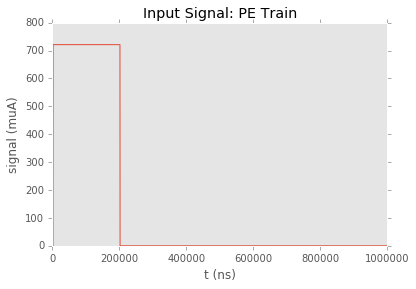

In [70]:
test_spe()

In [75]:
%lprun -f test_pulse_train test_pulse_train()

In [17]:
def simulate_pmt_response(event_number,pmtrd_):
    """
    Sensor Response
    Given a signal in PE (photoelectrons in bins of 1 ns) and the response function of 
    for a single photoelectron (spe) and front-end electronics (fee)
    this function produces the PMT raw data (adc counts bins 25 ns)

    pmtrd_ dataset that holds the PMT PE data for each PMT
    pmtrd25 dataset to be created with adc counts, bins 25 ns 
    after convoluting with electronics
    """
  
    rdata = []

    for j in range(pmtrd_.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        pmt = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        print(pmt.dtype)
        
        fee = FE.FEE(C=FP.C12[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN) 
        spe = SP.SPE(pmt_gain=FP.PMT_GAIN,x_slope = 5*ns,x_flat = 1*ns)
    
        signal_PMT = spe.SpePulseFromVectorPE(pmt) #PMT response

        #Front end response to PMT pulse (in volts)
        signal_fee = fee.FEESignal(signal_PMT, noise_rms=FP.NOISE_FEE) 
        print(signal_fee.dtype)

        #Signal out of DAQ
        #positive signal convention
        #signal_daq = fee.daqSignal(signal_fee, noise_rms=0) - FP.offset
        #negative signals convention!

        signal_daq = FP.offset -fee.daqSignal(signal_fee, noise_rms=0) 
    
        rdata.append(signal_daq)
    return np.array(rdata)




In [53]:
%%cython
import numpy as np
cimport numpy as np
import FEParam as FP
import SPE as SP
from scipy import signal as SGN
from Util import *

###########################################################
class SPE:

    def __init__(self,float pmt_gain=4.5e6, float x_slope = 5, float x_flat = 1):
        """
        Defines a spe 
        """
        self.pmt_gain=pmt_gain
        self.x_slope=x_slope
        self.x_flat=x_flat
    
        self.spe_base = self.x_slope + self.x_flat
        self.spe_length = 2*self.x_slope + self.x_flat

        self.A=self.pmt_gain*eplus/self.spe_base  #current  
        self.V = self.A*FP.spe_i_to_v()
        self.nADC = int(self.A*FP.spe_i_to_adc())

        self.t = np.arange(0,self.spe_length,FP.time_step)
    
        cdef int nns,nnf
        nns = int(self.x_slope/FP.time_step)
        nnf = int(self.x_flat/FP.time_step)
        rise = np.linspace(0,self.A, num=nns)
        fall = np.linspace(self.A,0, num=nns)
        flat = self.A*np.ones(nnf)
        self.spe=np.concatenate((rise,flat,fall))
         
    def Spe(self):
        """
        Returns a SPE
        """
        return self.t,self.spe

    def SpePulse(self,float t0, float tmax=1e+6):
        """
        Returns a SPE pulse at time t0
        with baseline extending in steps of time_step from 0 to tmax determined by DELTA_L
        """
        cdef int n, nmax
        n = int(t0/FP.time_step)
        nmax = int(tmax/FP.time_step)
        if n >= nmax:
            print("error in SpePulse n = {} nmax = {} ".format(n, nmax))
            sys.exit()

    
        DELTA=np.zeros(nmax)   #Dirac delta of size DELTA_L
        DELTA[n]=1
        step = FP.time_step/ns
        spe_pulse_t =np.arange(0,len(DELTA) + len(self.spe) -1,step)
        spe_pulse = SGN.convolve(DELTA, self.spe)
    
        return spe_pulse_t,spe_pulse

    def SpePulseTrain(self,tlow,tup,tmax=1e+6*ns):
        """
        Returns a train of SPE pulses between tlow and tup separated by tstep
        """
        nmin = int(tlow/FP.time_step)
        nmax = int(tup/FP.time_step)
        NMAX = int(tmax/FP.time_step)
        step = FP.time_step/ns

        if nmax >= NMAX:
            print("error in SpePulse train nmax = {} NMAX = {} ".formar(nmax, NMAX))
            sys.exit()

        DELTA=np.zeros(NMAX)
        DELTA[nmin:nmax+1] = 1
        spe_pulse_t =np.arange(0,len(DELTA) + len(self.spe) -1,step)
        spe_pulse = SGN.convolve(DELTA, self.spe)
      
        return spe_pulse_t,spe_pulse

    def SpePulseFromVectorPE(self,cnt):
        """
        Returns a train of SPE pulses corresponding to vector cnt
        """
    
        spe_pulse = SGN.convolve(cnt[0:-len(self.spe)+1], self.spe)
      
        return spe_pulse

 
def down_scale_signal_(double [:] signal, int scale):
    """
    downscales the signal vector. Re-scale the energy
    """
    signal_d=SGN.decimate(signal,scale,ftype='fir')

    return signal_d

##########################################################
cdef class Filter:
    
    cdef int ftype
    cdef float fc, fs 

    def __init__(self,ftype,fc, fs):
        """
        Defines a Butterworth HPF (high pass frequency) or LPF (low pass frequencey) filter 
        the default sampling frequencey is 1 GHz (inverse of 1 ns time)
        type may be equal to hig or low
        """
        self.fc = fc
        self.fs = fs
        self.W = 2*self.fc/self.fs
        if ftype == 1:
            self.b, self.a = SGN.butter(1, self.W, btype='high', analog=False, output='ba')
            self.ba, self.aa = SGN.butter(1, 2*self.fc, btype='high', analog=True, output='ba')
        else:
            self.b, self.a = SGN.butter(1, self.W, btype='low', analog=False, output='ba')
            self.ba, self.aa = SGN.butter(1, 2*self.fc, btype='low', analog=True, output='ba')

    def FilterCoef(self):
        """
        Returns the filter coefficients
        """
        return self.b,self.a

    def FilterAnalogCoef(self):
        """
        Returns the filter coefficients
        """
        return self.ba,self.aa

    
    def FilterPulse(self,double [:] pulse):
        """
        Filters a pulse
        """
        return SGN.lfilter(self.b,self.a, pulse)

    def FilterResponse(self):
        """
        Gives the response of the filter y frequency-amplitude
        """

        self.w, self.h = SGN.freqs(self.ba, self.aa)
        return self.w, self.h



###########################################################

cdef class FEE:
    """
    Emulates the effect of the PMT + FEE:
    1) PMT gain G
    2) A HPF, due to the FEE decoupling capacitor C and the associated series resitor R
    3) A LPF that shapes the signal, with a frequencey f and a noise
    4) A resitor gain RG to transform current in voltage
    """

    cdef float PMTG, C, R, f, fn, RG
    def __init__(self, PMTG, C, R, f, fn, RG):
        
        self.PMTG = PMTG
        self.C = C
        self.R = R
        self.f_LPF = f
        self.fn_LPF = fn
        self.RG = RG
        self.f_HPF=(1./(2*np.pi*R*C))
        self.hpf = Filter(ftype=1,fc=self.f_HPF,fs=FP.f_sample)
        self.lpf = Filter(ftype=0,fc=self.f_LPF,fs=FP.f_sample)
        self.hpfr = Filter(ftype=1,fc=self.f_HPF,fs=FP.f_sample_DAQ)


    def Filter(self,double [:] signal):
        """
        for an input signal in pes, returns the effect of the electronics
        """

        signal_hp = self.hpf.FilterPulse(signal)
        signal_hp_lp = self.lpf.FilterPulse(signal_hp)
        return signal_hp, signal_hp_lp
    
    def FilterInverse(self, double [:] signal):
        """
        Returns the inverse of the HPF filter in bins of 1ns
        """
        b_HPr,a_HPr = self.hpf.FilterCoef()
        h_t_inv = SGN.lfilter(a_HPr,b_HPr, signal)
        return h_t_inv

    def FilterInverseDAQ(self, double[:] signal):
        """
        Returns the inverse of the HPF filter in bins of time_DAQ (25 ns)
        """
        b_HPr,a_HPr = self.hpfr.FilterCoef()
        h_t_inv = SGN.lfilter(a_HPr,b_HPr, signal)
        return h_t_inv

    def FEESignal(self,double [:] signal_current, float noise_rms=0.3):
        """
        filters the input signal according to the filters and transforms it in volts
        """
        signal_hp, signal_hp_lp = self.Filter(signal_current)
        noise = self.FEENoise(len(signal_current), noise_rms)
        return signal_hp_lp*self.RG + noise
    
#     def DAQSignal(self,signal_t, signal_fee, noise_rms=0.3):
#         """
#         downscale the signal after the FEE
#         """

#         signal_t_d, signal_d = DownScaleSignal(signal_t, signal_fee, int(FP.time_DAQ))
#         signal_daq = signal_d/FP.voltsToAdc
#         noise = self.FEENoise(len(signal_daq), noise_rms/FP.voltsToAdc)
#         return signal_t_d, signal_daq + noise

    def daqSignal(self, double [:] signal_fee, float noise_rms=FP.NOISE_FEE_rms):
        """
        downscale the signal after the FEE
        """
        signal_d = down_scale_signal_(signal_fee, int(FP.time_DAQ))
        signal_daq = signal_d/FP.voltsToAdc
        noise = self.FEENoise(len(signal_daq), noise_rms/FP.voltsToAdc)
        return signal_daq + noise

    def FEENoise(self, int signal_length, float noise_rms=FP.NOISE_FEE_rms):
        """
        filters the input signal according to the filters and transforms it in volts
        """
        if noise_rms > 0:
            noise = np.random.normal(0, noise_rms, signal_length)
            return noise
        else:
            return np.zeros(signal_length)

    def VSignal(self,double [:] signal_current):
        """
        Takes a current input signal and transforms it to volts
         """
        cdef int i;
        for i in range(len(signal_current)):
            signal_current[i] = signal_current[i]*self.RG
            
        return signal_current
        
    def InverseSignal(self, double [:] signal_t):
        """
        Computes the inverse signal for deconvolution 
        """
        pulse = np.zeros(len(signal_t))
        pulse[0]=1
        signal_fee_inv = self.FilterInverse(pulse)
        return signal_fee_inv

    def InverseSignalDAQ(self, double[:] signal_t):
        """
        Computes the inverse signal in bins of DAQ
        """
        pulse = np.zeros(len(signal_t))
        pulse[0]=1
        signal_daq_inv = self.FilterInverseDAQ(pulse)
        return signal_daq_inv



cpdef simulate_pmt_response_cy(int event_number,np.ndarray[np.float32_t, ndim=1] C12, 
                             float R, float freq_LPF, float V_GAIN, pmtrd_):
    """
    Sensor Response
    Given a signal in PE (photoelectrons in bins of 1 ns) and the response function of 
    for a single photoelectron (spe) and front-end electronics (fee)
    this function produces the PMT raw data (adc counts bins 25 ns)

    pmtrd_ dataset that holds the PMT PE data for each PMT
    pmtrd25 dataset to be created with adc counts, bins 25 ns 
    after convoluting with electronics
    """
  
    cdef list rdata = []
    cdef int j
    
    cdef np.ndarray[np.float32_t, ndim=1] pmt=np.empty(pmtrd_.shape[2], dtype=np.float32)
    for j in range(pmtrd_.shape[1]):
       
        pmt = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        
        fee = FEE(C=FP.C12[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN) 
        spe = SP.SPE(pmt_gain=FP.PMT_GAIN,x_slope = 5,x_flat = 1)
        
        signal_PMT = spe.SpePulseFromVectorPE(pmt) #PMT response

        #Front end response to PMT pulse (in volts)
       
        signal_fee = fee.FEESignal(signal_PMT, noise_rms=FP.NOISE_FEE) 

        #Signal out of DAQ
        #positive signal convention
        #signal_daq = fee.daqSignal(signal_fee, noise_rms=0) - FP.offset
        #negative signals convention!

        signal_daq = FP.offset -fee.daqSignal(signal_fee, noise_rms=0) 
    
        rdata.append(signal_daq)
    return np.array(rdata)





In [9]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5')

In [15]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(1000, 12, 1200000), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/sipmrd (EArray(1000, 1789, 1200), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 1200)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/MCT

In [10]:
pmtrd = h5f.root.pmtrd

In [11]:
pmt = pmtrd[0,0]

In [12]:
pmt.dtype

dtype('float32')

In [35]:
pmtrd.shape

(1000, 12, 1200000)

In [36]:
np.amax(pmt)

4.0

In [33]:
ar = simulate_pmt_response_cy(0,pmtrd)

In [ ]:
%lprun -f simulate_pmt_response simulate_pmt_response(0,pmtrd)

In [ ]:
%prun -l ipython-input-5-4f40c51d5c72 simulate_pmt_response(0,pmtrd)

 15269 function calls in 1.845 seconds

   Ordered by: internal time
   List reduced from 109 to 8 due to restriction <u'ipython-input-5-4f40c51d5c72'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       12    0.087    0.007    0.763    0.064 <ipython-input-5-4f40c51d5c72>:157(FEESignal)
       12    0.011    0.001    0.534    0.045 <ipython-input-5-4f40c51d5c72>:177(daqSignal)
       36    0.000    0.000    0.019    0.001 <ipython-input-5-4f40c51d5c72>:56(__init__)
       12    0.000    0.000    0.020    0.002 <ipython-input-5-4f40c51d5c72>:117(__init__)
       24    0.000    0.000    0.180    0.008 <ipython-input-5-4f40c51d5c72>:81(FilterPulse)
       24    0.000    0.000    0.495    0.021 <ipython-input-5-4f40c51d5c72>:188(FEENoise)
       12    0.000    0.000    0.181    0.015 <ipython-input-5-4f40c51d5c72>:132(Filter)
       12    0.000    0.000    0.523    0.044 <ipython-input-5-4f40c51d5c72>:22(down_scale_signal_)

In [ ]:
simulate_pmt_response(0,pmtrd)

In [56]:
%timeit simulate_pmt_response_cy(0,FP.C12,FP.R, FP.freq_LPF, FP.V_GAIN, pmtrd)

ValueError: Buffer dtype mismatch, expected 'float32_t' but got 'double'